Czas na wstęp do zagadnień analiz czas-częstość

In [29]:
import os
from os.path import join
import numpy as np

epochs_dir = r'C:\Users\swps\Dropbox\CURRENT PROJECTS\mozg-rozpajton-2016-2017\clean epochs'
processed_dir = r'C:\Users\swps\Dropbox\CURRENT PROJECTS\mozg-rozpajton-2016-2017\CAT processed'
files = os.listdir(epochs_dir)

# wyświetlmy pierwsze dwa pliki, tak aby zobaczyć, że lista się utworzyła:
print(files[:2])

['CAT101-epo.fif', 'CAT106-epo.fif']


In [18]:
from mne import read_epochs

# weźmy przykładowy plik
this_file = files[6]
epochs = read_epochs(join(epochs_dir, this_file))

Reading C:\Users\swps\Dropbox\CURRENT PROJECTS\mozg-rozpajton-2016-2017\clean epochs\CAT206-epo.fif ...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 65) active
    Found the data of interest:
        t =    -248.00 ...     752.00 ms (None)
        0 CTF compensation matrices available
375 matching events found
Created an SSP operator (subspace dimension = 1)
375 matching events found
Created an SSP operator (subspace dimension = 1)
1 projection items activated


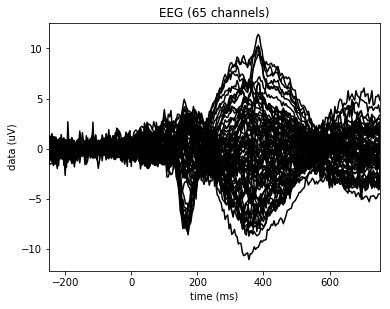

In [3]:
%matplotlib inline
epochs.average().plot();

In [4]:
# zobaczmy jaki jest czas pierwszej próbki:
first_t = epochs.times[0]
print(first_t)

-0.248


Tyle ms mamy dla czasu przed prezentacją bodźca to niestety mało dla analiz częstotliwościowych.
To dlatego, że aby oszacować zawartość pewnych częstotliwości w sygnale trzeba mieć odpowiednio długi sygnał. Analizy częstotliwościowe robi się na odpowiednio długich odcinkach sygnału. Przyjmuje się, że w ramach danego odcinka, aby dobrze oszacować jak dużo jest pewnej częstotliwości, trzeba mieć minimum długość sygnału równą trzem cyklom danej częstotliwości.
Tzn. bardziej konkretnie, powiedzmy, że interesuje nas 10 Hz. 10 Hz to innymi słowy 10 cykli na sekundę, a co za tym idzie jeden cykl trwa 100 ms (`1000 / 10`). Aby dobrze oszacować ile jest częstotliwości 10 Hz musimy mieć co najmniej ok. 3 cykli tej częstotliwości w sygnale tzn. 3 * 100 - 300 ms sygnału. W baselinie mamy mniej niż 300 ms.
Ale zacznijmy najpierw od spraw najprostszych - policzymy widmo (wkład różnych częstotliwości do sygnału) dla samego baseline'u:

In [5]:
from mne.time_frequency import psd_welch

In [6]:
widmo, freq = psd_welch(epochs, tmax=0.)

Effective window size : 0.252 (s)


In [7]:
# teraz widmo to macierz z widmem o wymiarach: epoki x kanały x częstotliwości
print(widmo.shape)

(375, 65, 32)


In [8]:
# na razie uśrednimy epoki, interesują nas tylko elektrody x częstotliwości
avg_widmo = widmo.mean(axis=0)

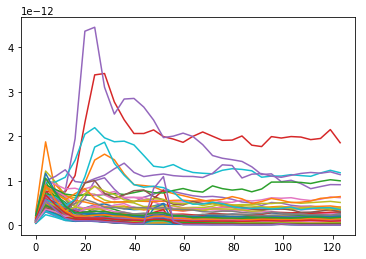

In [9]:
# zobaczmy jak to widmo wygląda:
import matplotlib.pyplot as plt

plt.plot(freq, avg_widmo.T);

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:8: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 65 but corresponding boolean dimension is 32


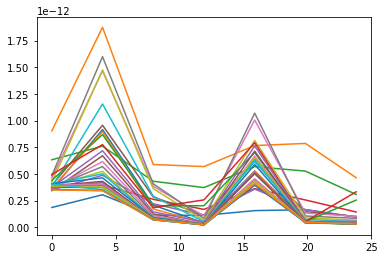

In [10]:
# w przypadku tego pliku dużo się nie dowiadujemy:
# widzimy że część kanałów ma sporo wysokich częstotliwości (mięśnie)
# inna część ma z kolei pewien udział sieci elektrycznej - widzimy czubek w 50 Hz

# zobaczmy może tylko do 25 Hz widmo
# znajdźmy 25 Hz
freq_mask = freq < 25.
plt.plot(freq[freq_mask], avg_widmo[freq_mask]);

Zobaczcie że mamy informacje dla częstotliwości, których 3 cykle nie mieszczą się w sygnale. To dlatego, że ta analiza (welch) zakłada, że wystarczy nam 1 cykl danej częstotliwości aby oszacować jej wkład do sygnału.
Sprawdźmy jaka jest najniższa częstotliwość, która została oszacowana w naszym baseline - ta informacja znajduje się w freq[1]:

In [11]:
freq[1]

3.9682539682539684

In [12]:
# obliczamy widmo dla odcinka po bodźcu
widmo2, freq = psd_welch(epochs, tmin=0., tmax=np.abs(first_t))

Effective window size : 0.252 (s)


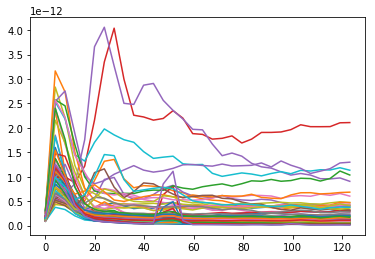

In [13]:
avg_widmo2 = widmo2.mean(axis=0)
plt.plot(freq, avg_widmo2.T);

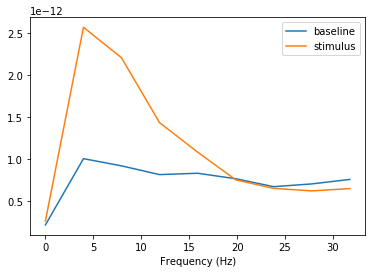

In [14]:
# wybierzmy dowolny kanał np. 'E47' i porównajmy przed (avg_widmo) i po (avg_widmo2)
ch_ind = epochs.ch_names.index('E47')

freq_mask = freq < 35.
plt.plot(freq[freq_mask], avg_widmo[ch_ind, freq_mask], label='baseline')
plt.plot(freq[freq_mask], avg_widmo2[ch_ind, freq_mask], label='stimulus')
plt.legend()
plt.xlabel('Frequency (Hz)')

Widzimy wzrost niskich częstotliwości po prezentracji bodźca - to nie jest zaskakujące zważywszy na to, że potencjał wywołany, który jest obecny w naszym sygnale, składa się w zasadzie w całości z niskich częstotliwości.
Zanim zajmiemy się zmianami częstotliwości w czasie postaraamy się odtworzyć te same epoki ale o większym zakresie czasowym. Aby to zrobić sprawdzamy najpierw, które epoki zostały dla danego pliku odrzucone (aby odrzucić te same, gdy skonstruujemy dłuższe epoki).

In [15]:
from mypy.events import get_dropped_epoch_index

dropped_ind = get_dropped_epoch_index(epochs)
print(dropped_ind)

[12, 15, 31, 47, 94, 95, 96, 145, 156, 157, 158, 237, 238, 241, 267, 268, 269, 314, 324, 347, 350, 357, 384, 394, 395, 396, 398, 402, 403]


In [30]:
raw_files_dir = r'C:\Users\swps\Dropbox\DANE\CAT N170\EEG\RAW'
raw_files = [f for f in os.listdir(raw_files_dir) if f.endswith('.raw')]
ica_files = [f for f in os.listdir(processed_dir) if f.endswith('-ica.fif')]
print(raw_files[:3])
print(ica_files[:3])

['CAT101 20130518 1906002.raw', 'CAT106 20131027 1538002.raw', 'CAT107 20131027 1648002.raw']
['Barszczewska CAT304 20130723 1522002-ica.fif', 'CAT106 20131027 1538002-ica.fif', 'CAT114 20131125 1944002-ica.fif']


In [33]:
# poniżej tworzymy funkcję do wczytywania szerszych epok, przeczytajcie ją sobie uważnie:

import os.path as op
import mne
from mne.io import read_raw_egi
from mne.preprocessing import read_ica

from mypy.chans import correct_egi_channel_names
from mypy.events import get_events_from_din


def zrób_szersze_epoki(this_file, dropped_ind):
    # szukamy w raw_files pliku odpowiadającego danym epokom:
    file_id = this_file.replace('-epo.fif', '')
    corresp_raw = [f for f in raw_files if file_id in f]

    # sprawdzamy czy znaleźliśmy
    if len(corresp_raw) > 0:
        corresp_raw = corresp_raw[0]
        print('Znaleziony surowy plik odpowiadający epokom: {}'.format(corresp_raw))
    else:
        raise RunTimeError('Nie znaleziono odpowiedniego pliku surowego :(')

    # tworzymy pełną ścieżkę do pliku i wczytujemy plik
    file_path = op.join(raw_files_dir, corresp_raw)
    raw = read_raw_egi(file_path, preload=True, verbose=False)

    # filtrowanie i montaż
    raw.filter(0.5, None)
    montage = mne.channels.read_montage('GSN-HydroCel-65_1.0')
    correct_egi_channel_names(raw)
    raw.set_montage(montage)

    # bierzemy wydarzenia z kanałów DIN
    events = get_events_from_din(raw)

    # teraz tworzymy słownik tylko z wydarzeniami, względem których będziemy epokować:
    event_id = { "car/0": 36, "car/90": 40, "car/180": 44,
                "face/0": 52, "face/90": 56, "face/180": 60}

    # epokujemy
    # UWAGA - tutaj zmieniliśmy tmin i tmax
    epochs = mne.Epochs(raw, events, tmin=-0.6, tmax=1.5,
                        event_id=event_id, preload=True)

    # ustawiamy referencję do średniej - porównamy sobie co nam zmienia
    # (o ref do średniej zrobię jeszcze jakiś tutorial / notebook)
    epochs.set_eeg_reference()

    # na koniec usuwamy te same epoki, które zostały usunięte we wcześniejszych epokach
    epochs.drop(dropped_ind)

    # szukamy i wczytujemy jeszcze ica
    corresp_ica = [f for f in ica_files if file_id in f]
    corresp_ica = corresp_ica[0]
    ica = read_ica(op.join(processed_dir, corresp_ica))

    # stosujemy ica oraz ostatnie kroki (tak jak w zajecia_4.ipynb)
    epochs = ica.apply(epochs)

    # interpolujemy złe kanały
    if len(epochs.info['bads']) > 0:
        epochs.interpolate_bads()

    # tworzymy referencję do średniej
    epochs.set_eeg_reference()

    # i stosujemy ją do danych (przekształcamy dane)
    epochs.apply_proj()

    # ach, no i wybieramy tylko kanały eeg (kanały z triggerami już dawno nie są nam potrzebne)
    epochs.pick_types(eeg=True)
    return epochs

In [34]:
# teraz korzystamy z tej funkcji:
epochs_long = zrób_szersze_epoki(this_file, dropped_ind)
print(epochs_long)

Znaleziony surowy plik odpowiadający epokom: CAT206 20131103 1727002.raw
404 matching events found
0 projection items activated
Loading data for 404 events and 526 original time points ...
0 bad epochs dropped
Adding average EEG reference projection.
1 projection items deactivated
Dropped 29 epochs
Reading C:\Users\swps\Dropbox\CURRENT PROJECTS\mozg-rozpajton-2016-2017\CAT processed\CAT206 20131103 1727002-ica.fif ...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 65) active
Now restoring ICA solution ...
Ready.
Transforming to ICA space (27 components)
Zeroing out 9 ICA components
An average reference projection was already added. The data has been left untouched.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...


<ipython-input-33-2209b843b74e>:66: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  epochs.set_eeg_reference()


<Epochs  |  n_events : 375 (all good), tmin : -0.6 (s), tmax : 1.5 (s), baseline : (None, 0), ~97.9 MB, data loaded,
 'car/0': 63, 'car/180': 62, 'car/90': 65, 'face/0': 64, 'face/180': 59, 'face/90': 62>


In [35]:
# czas na czas-częstość!
# zdefiniujemy sobie częstotliwości:
freqs = np.linspace(3, 35, num=16)
freqs

array([  3.        ,   5.13333333,   7.26666667,   9.4       ,
        11.53333333,  13.66666667,  15.8       ,  17.93333333,
        20.06666667,  22.2       ,  24.33333333,  26.46666667,
        28.6       ,  30.73333333,  32.86666667,  35.        ])

In [37]:
# liczba cykli dla danej częstotliwości (definiuje szerokość okna analizy):
n_cycles = freqs / 2
n_cycles

# jeżeli dzielimy częstotliwość na 2 to wychodzi nam liczba cykli dla połowy sekundy

array([  1.5       ,   2.56666667,   3.63333333,   4.7       ,
         5.76666667,   6.83333333,   7.9       ,   8.96666667,
        10.03333333,  11.1       ,  12.16666667,  13.23333333,
        14.3       ,  15.36666667,  16.43333333,  17.5       ])

In [38]:
from mne.time_frequency import tfr_morlet

# sprawdźcie sobie help tej funkcji tutaj: 
# http://martinos.org/mne/stable/generated/mne.time_frequency.tfr_morlet.html

In [39]:
tfr_face = tfr_morlet(epochs_long['face/0'], freqs, n_cycles, use_fft=True,
                      return_itc=False, decim=10, picks=[ch_ind])

No baseline correction applied


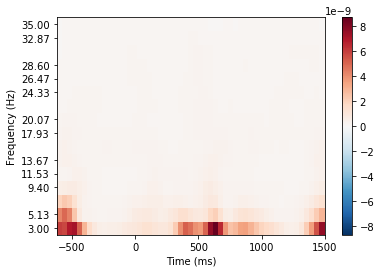

In [43]:
tfr_face.plot([0]);

Applying baseline correction (mode: mean)


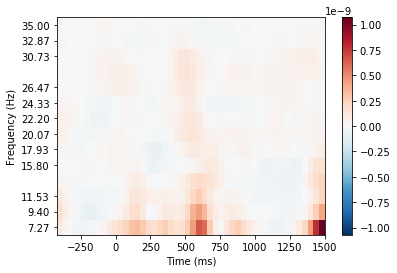

In [50]:
# wygląda dziwnie, nie? trzeba zrobić baseline - opcji jest sporo, sprawdzimy dwie:
# mode = 'mean'
tfr_face.plot([0], baseline=(-0.4, -0.1), mode='mean', fmin=7, tmin=-0.4);

Applying baseline correction (mode: percent)


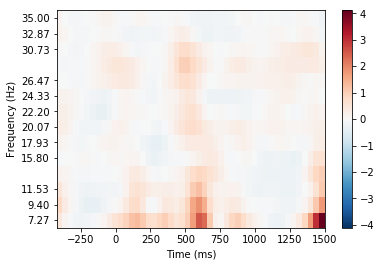

In [51]:
tfr_face.plot([0], baseline=(-0.4, -0.1), mode='percent', fmin=7, tmin=-0.4);